## Build Functions for ELT

In [1]:
# Install Requirments (Updated on 10/2/2024, streamlit 1.39.0)
# !pip3 install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from yfinance import Ticker
from pykalman import KalmanFilter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.model_selection import cross_val_predict

from datetime import datetime
import pytz

import pprint

from src import functions as f

%load_ext autoreload
%autoreload 2

### Download, Transform, and Modeling All in One

In [3]:
# manufactoring suppliers 
# 'lrcs', 'klac', ''

In [82]:
f.predictions('amd')

AMD 5m Interval Timestamp: 2024-11-03 02:42:47 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,static,static,static,static
kelly_1:2.5,0.376316,0.362906,0.362193,0.240404
prob_up,0.24003,0.310328,0.297615,0.125
prob_static,0.631518,0.465591,0.552136,0.875
prob_down,0.128452,0.22408,0.150249,0.0
precision,0.554511,0.544933,0.544423,0.457431
recall,0.571705,0.552326,0.55814,0.614341
f1,0.562977,0.548604,0.551196,0.5244
support,"[516.0, 516.0, 514.0]","[516.0, 516.0, 514.0]","[516.0, 516.0, 514.0]","[516.0, 516.0, 514.0]"


AMD 15m Interval Timestamp: 2024-11-03 02:42:54 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,down,up,static,static
kelly_1:2.5,0.209524,0.186047,0.458667,0.273333
prob_up,0.238633,0.389211,0.304758,0.125
prob_static,0.167887,0.316352,0.375778,0.625
prob_down,0.59348,0.294437,0.319464,0.25
precision,0.435374,0.418605,0.613333,0.480952
recall,0.380952,0.421053,0.531792,0.583815
f1,0.406349,0.419825,0.569659,0.527415
support,"[171.0, 173.0, 168.0]","[171.0, 173.0, 168.0]","[171.0, 173.0, 168.0]","[171.0, 173.0, 168.0]"


AMD 30m Interval Timestamp: 2024-11-03 02:42:57 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,down,down,static,static
kelly_1:2.5,0.197561,0.23,0.322581,0.23937
prob_up,0.149734,0.16312,0.193063,0.125
prob_static,0.387433,0.412209,0.479408,0.625
prob_down,0.462833,0.424671,0.327529,0.25
precision,0.426829,0.45,0.516129,0.456693
recall,0.416667,0.428571,0.571429,0.690476
f1,0.421687,0.439024,0.542373,0.549763
support,"[83.0, 84.0, 84.0]","[83.0, 84.0, 84.0]","[83.0, 84.0, 84.0]","[83.0, 84.0, 84.0]"


AMD 1h Interval Timestamp: 2024-11-03 02:43:00 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,static,static,static,static
kelly_1:2.5,0.393559,0.397674,0.423077,0.229126
prob_up,0.288493,0.323697,0.265742,0.0
prob_static,0.434597,0.388708,0.45358,0.625
prob_down,0.27691,0.287595,0.280678,0.375
precision,0.566828,0.569767,0.587912,0.449376
recall,0.64,0.623636,0.583636,0.589091
f1,0.601196,0.595486,0.585766,0.509835
support,"[549.0, 550.0, 550.0]","[549.0, 550.0, 550.0]","[549.0, 550.0, 550.0]","[549.0, 550.0, 550.0]"


AMD 1d Interval Timestamp: 2024-11-03 02:43:08 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,down,up,down,down
kelly_1:2.5,0.065464,0.092958,0.089133,0.029675
prob_up,0.342257,0.384362,0.351629,0.25
prob_static,0.30596,0.301407,0.286178,0.25
prob_down,0.351783,0.314231,0.362193,0.5
precision,0.332474,0.352113,0.349381,0.306911
recall,0.346309,0.301609,0.34094,0.202685
f1,0.33925,0.32491,0.345109,0.244139
support,"[746.0, 748.0, 745.0]","[746.0, 748.0, 745.0]","[746.0, 748.0, 745.0]","[746.0, 748.0, 745.0]"


AMD 1wk Interval Timestamp: 2024-11-03 02:43:17 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,up,up,static,up
kelly_1:2.5,-0.010526,-0.00625,0.06014,0.14
prob_up,0.517559,0.401397,0.387742,0.625
prob_static,0.337198,0.336324,0.403217,0.375
prob_down,0.145244,0.26228,0.209041,0.0
precision,0.278195,0.28125,0.328671,0.385714
recall,0.246667,0.3,0.309211,0.36
f1,0.261484,0.290323,0.318644,0.372414
support,"[150.0, 152.0, 152.0]","[150.0, 152.0, 152.0]","[150.0, 152.0, 152.0]","[150.0, 152.0, 152.0]"


AMD 1mo Interval Timestamp: 2024-11-03 02:43:20 


,XGBoost,GradientBoosting,RandomForest,KNN
prediction,up,static,up,static
kelly_1:2.5,0.105556,0.096774,0.24,0.08
prob_up,0.873744,0.366046,0.44692,0.375
prob_static,0.078892,0.387567,0.36554,0.375
prob_down,0.047365,0.246387,0.18754,0.25
precision,0.361111,0.354839,0.457143,0.342857
recall,0.433333,0.407407,0.533333,0.444444
f1,0.393939,0.37931,0.492308,0.387097
support,"[30.0, 27.0, 27.0]","[30.0, 27.0, 27.0]","[30.0, 27.0, 27.0]","[30.0, 27.0, 27.0]"


###### Check Summary Output

In [78]:
symbol='NVDA'
interval='1h'

f.transform(symbol, interval)

df = f.load_model_df(symbol,interval)

df.tail(7)

,top_z21,body_z21,bottom_z21,vol_z21,pct_gap_up_down_z21,ac_z5,ac_z8,ac_z13,ac_z21,kma_sma40_diff_z21,day_of_month,day_of_week,hour_of_day,cluster,direction
Datetime,,,,,,,,,,,,,,,
2024-11-01 13:30:00-04:00,-0.961087,0.711753,0.037443,0.300145,-0.235387,-1.491527,-0.395775,-0.038006,0.575446,1.973350,1,4,13,1.0,0
2024-11-01 14:30:00-04:00,1.663648,-0.924956,-0.530293,0.085590,-0.213838,-0.895264,-0.392433,-0.028773,0.604615,1.856448,1,4,14,1.0,2
2024-11-01 15:30:00-04:00,0.725207,-0.875233,0.274680,0.146845,-0.243156,-0.882898,-0.691363,-0.350655,0.413490,1.720688,1,4,15,0.0,0
2024-11-01 16:00:00-04:00,2.366807,-1.337534,-1.100366,-0.744200,-0.251631,-0.568610,-0.928648,-0.374915,0.356581,1.627606,1,4,16,0.0,1
2024-11-01 17:00:00-04:00,-1.015680,1.202801,-0.230884,-0.685051,-0.248707,1.787018,2.164461,2.497075,2.583478,1.774044,1,4,17,1.0,1
2024-11-01 18:00:00-04:00,-0.477343,-1.067219,1.677383,-0.615305,-0.215875,1.157741,1.647850,1.993478,2.279491,1.861851,1,4,18,1.0,0
2024-11-01 19:00:00-04:00,-0.085838,-0.182292,0.294521,-0.548359,-0.227472,0.821796,1.293787,1.682540,2.098871,1.907701,1,4,19,1.0,NaN


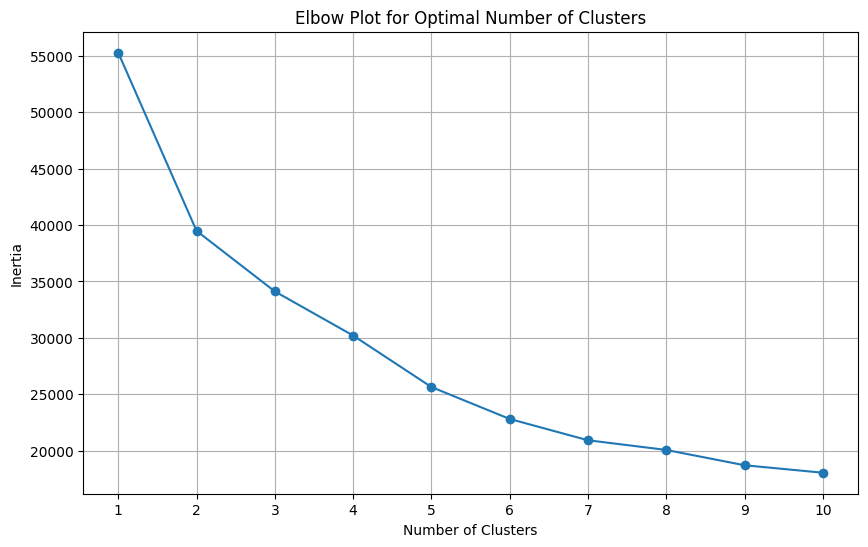

In [79]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select columns ending with 'z21'
z_columns = ['ac_z5', 'ac_z8', 'ac_z13', 'ac_z21', 'top_z21', 'body_z21', 'bottom_z21', 'vol_z21', 'pct_gap_up_down_z21', 'kma_sma40_diff_z21']
data_z21 = df[z21_columns].dropna()  # Drop rows with missing values for simplicity

# Create an elbow plot to find the optimal number of clusters
inertia = []
cluster_range = range(1, 11)  # Test for clusters from 1 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_z21)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


In [80]:
optimal_k = 3  # Replace with the optimal number from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_z21['cluster'] = kmeans.fit_predict(data_z21)

# Check the cluster distribution
print(data_z21['cluster'].value_counts())

cluster
2    3722
0    2733
1    1789
Name: count, dtype: int64


In [63]:
# Add the 'cluster' column back to the original DataFrame
df['cluster'] = data_z21['cluster']



In [71]:
symbol='NVDA'
interval='1d'

# # Define Eastern Time Zone
# eastern = pytz.timezone('US/Eastern')

# # Get current time in Eastern Time Zone
# eastern_time = datetime.now(eastern)

# # Format the time to include hour, minute, and seconds
# time_stamp = eastern_time.strftime('%Y-%m-%d %H:%M:%S')

# print(f'DL Time: {time_stamp}')

# f.download(symbol, interval, period)
f.transform(symbol, interval)
curr_prediction, models, feature_names, classification_reports = f.model(symbol, interval)
predictions, prediction_probas = f.make_prediction(models, curr_prediction, feature_names)

f.predictions_summary(predictions, prediction_probas, classification_reports)

,model,prediction,kelly_1:2.5,prob_up,prob_static,prob_down,precision,recall,f1,support
0,XGBoost,static,0.110970,0.408259,0.509516,0.082225,0.364979,0.401392,0.382320,"[428.0, 431.0, 427.0]"
1,GradientBoosting,static,0.131610,0.379904,0.470721,0.149374,0.379722,0.443155,0.408994,"[428.0, 431.0, 427.0]"
2,RandomForest,static,0.119843,0.325298,0.385855,0.288847,0.371316,0.438515,0.402128,"[428.0, 431.0, 427.0]"
3,KNN,down,0.052667,0.250000,0.250000,0.500000,0.323333,0.227166,0.266850,"[428.0, 431.0, 427.0]"


In [72]:
models

{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.06, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=175, n_jobs=-1,
               num_parallel_tree=None, objective='multi:softprob', ...),
 'GradientBoosting': GradientBoostingClassifier(learning_rate=0.11, max_depth=5, max_features='sqrt',
                            n_estimators=83, n_iter_no_change=17,
                            random_state=42, sub

In [73]:
models['XGBoost'].feature_importances_

array([0.01782188, 0.00958141, 0.02308899, 0.01949731, 0.0307939 ,
       0.02006624, 0.02560585, 0.03082045, 0.0165486 , 0.01863871,
       0.        , 0.00458632, 0.02438448, 0.0113591 , 0.01996448,
       0.04077864, 0.02840263, 0.01840734, 0.02760903, 0.02938329,
       0.01335408, 0.02523802, 0.03845488, 0.02110608, 0.01492553,
       0.01476613, 0.02712568, 0.02053206, 0.02997154, 0.02046464,
       0.02759656, 0.02413173, 0.01855196, 0.0173187 , 0.02527468,
       0.02383312, 0.        , 0.02036536, 0.        , 0.02162302,
       0.02082483, 0.02106236, 0.02184576, 0.02300566, 0.02210692,
       0.02298369, 0.02543798, 0.02076045], dtype=float32)

In [74]:
feature_names

['day_of_month_1',
 'day_of_month_2',
 'day_of_month_3',
 'day_of_month_4',
 'day_of_month_5',
 'day_of_month_6',
 'day_of_month_7',
 'day_of_month_8',
 'day_of_month_9',
 'day_of_month_10',
 'day_of_month_11',
 'day_of_month_12',
 'day_of_month_13',
 'day_of_month_14',
 'day_of_month_15',
 'day_of_month_16',
 'day_of_month_17',
 'day_of_month_18',
 'day_of_month_19',
 'day_of_month_20',
 'day_of_month_21',
 'day_of_month_22',
 'day_of_month_23',
 'day_of_month_24',
 'day_of_month_25',
 'day_of_month_26',
 'day_of_month_27',
 'day_of_month_28',
 'day_of_month_29',
 'day_of_month_30',
 'day_of_month_31',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'hour_of_day_0',
 'cluster_0.0',
 'cluster_1.0',
 'top_z21',
 'body_z21',
 'bottom_z21',
 'vol_z21',
 'pct_gap_up_down_z21',
 'ac_z5',
 'ac_z8',
 'ac_z13',
 'kma_sma40_diff_z21']

In [76]:
merged_list = sorted(zip(feature_names, models['XGBoost'].feature_importances_),
                     key=lambda x: x[1], 
                     reverse=True
                    )
merged_list

[('day_of_month_16', np.float32(0.040778637)),
 ('day_of_month_23', np.float32(0.03845488)),
 ('day_of_month_8', np.float32(0.030820446)),
 ('day_of_month_5', np.float32(0.030793903)),
 ('day_of_month_29', np.float32(0.02997154)),
 ('day_of_month_20', np.float32(0.029383292)),
 ('day_of_month_17', np.float32(0.028402628)),
 ('day_of_month_19', np.float32(0.02760903)),
 ('day_of_month_31', np.float32(0.027596561)),
 ('day_of_month_27', np.float32(0.02712568)),
 ('day_of_month_7', np.float32(0.025605852)),
 ('ac_z13', np.float32(0.025437975)),
 ('day_of_week_3', np.float32(0.025274683)),
 ('day_of_month_22', np.float32(0.025238018)),
 ('day_of_month_13', np.float32(0.024384484)),
 ('day_of_week_0', np.float32(0.02413173)),
 ('day_of_week_4', np.float32(0.023833118)),
 ('day_of_month_3', np.float32(0.023088986)),
 ('pct_gap_up_down_z21', np.float32(0.023005657)),
 ('ac_z8', np.float32(0.022983693)),
 ('ac_z5', np.float32(0.022106916)),
 ('vol_z21', np.float32(0.021845762)),
 ('top_z21', n

In [ ]:
predictions

In [ ]:
classification_reports

### Hyperparameter Searches

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

def model(symbol, interval, search_type='none'):
    # Load data
    data = f.load_model_df(symbol, interval)
    data.dropna(inplace=True, axis=0)
    X = data.drop(columns=['direction'], axis=1)
    y = data['direction']
    
    # Print column names to check for issues
    print("Columns in X before preprocessing:")
    print(X.columns)
    
    # Remove duplicate columns
    X = X.loc[:, ~X.columns.duplicated()]
    
    # Check if categorical_features are present in X
    categorical_features = ['day_of_month', 'day_of_week', 'hour_of_day']
    missing_features = [col for col in categorical_features if col not in X.columns]
    if missing_features:
        print(f"Missing categorical features: {missing_features}")
    
    # Store current prediction data (last row)
    curr_prediction = X.iloc[-1].copy()

    # Drop last row from X and y to prevent the model from seeing it
    X = X.iloc[:-1]
    y = y.iloc[:-1]
    
    # Create the categorical transformer
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # Create the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features)
        ],
        force_int_remainder_cols=False # This will include all other columns in the transformed output
    )
    
    # Define your models
    models = {
        'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingClassifier(random_state=42, validation_fraction=0.25, n_iter_no_change=31),
        # 'LightGBM': LGBMClassifier(random_state=42,force_col_wise=True),
        'KNN': KNeighborsClassifier(n_neighbors=7, p=1,weights='distance')
    }
    
    # Hyperparameters to search
    param_grids = {
        'XGBoost': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3]
        },
        'RandomForest': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10, 13]
        },
        'GradientBoosting': {
            'classifier__n_estimators': [100, 200, 300, 400],
            'classifier__max_depth': [3, 5, 7, 13],
            'classifier__le||arning_rate': [0.01, 0.1, 0.2, 0.5]
        },
        'KNN': {
            'classifier__n_neighbors': [3, 5, 7, 13],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]  # 1: Manhattan, 2: Euclidean
        }
    }
    
    # Create a function to get feature names after transformation
    def get_feature_names_out(column_transformer):
        feature_names = []
        for name, transformer, columns in column_transformer.transformers_:
            if transformer == 'drop' or transformer == 'passthrough':
                if transformer == 'passthrough':
                    feature_names.extend(columns)
                continue
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            else:
                feature_names.extend(columns)
        return feature_names
    
    # Split data before preprocessing to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42)
    
    # Fit the preprocessor on training data
    preprocessor.fit(X_train)
    
    # Transform training and test data
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Get feature names after transformation
    feature_names = get_feature_names_out(preprocessor)
    
    # Convert transformed data to DataFrame
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
    
    # Transform curr_prediction
    curr_prediction_transformed = preprocessor.transform(
        curr_prediction.to_frame().T)
    curr_prediction_transformed = pd.DataFrame(
        curr_prediction_transformed, columns=feature_names)
    
    for model_name, model in models.items():
        # Create a pipeline with the classifier
        pipeline = Pipeline(steps=[
            ('classifier', model)
        ])
        
        # Get the parameter grid for the current model
        param_grid = param_grids.get(model_name, {})
        
        # Use GridSearchCV or RandomizedSearchCV
        if search_type == 'grid' and param_grid:
            search = GridSearchCV(
                pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        elif search_type == 'random' and param_grid:
            search = RandomizedSearchCV(
                pipeline, param_grid, cv=5, scoring='accuracy',
                n_jobs=-1, n_iter=10, random_state=42)
        else:
            search = pipeline
        
        # Fit the model
        search.fit(X_train_transformed, y_train)
        
        # If using search, get the best estimator
        if search_type in ['grid', 'random'] and param_grid:
            best_model = search.best_estimator_
            print(f"Best parameters for {model_name}: {search.best_params_}")
            model = best_model.named_steps['classifier']
        else:
            model = search.named_steps['classifier']
        
        # Store the model
        models[model_name] = model
        
        # Predict on test data
        y_pred = search.predict(X_test_transformed)
        
        # Evaluate the model
        print(f"Model: {model_name}")
        print(classification_report(y_test, y_pred, zero_division=0))
    
    return curr_prediction_transformed, models, feature_names

In [ ]:
curr_prediction, models, feature_names = model('AMD', '5m', 'grid')